# 1) Player segmentation

## Approach -

My approach and strategy to segment the players from the given data sets would be to first clean the data and do some basic feature engineering & implement the RFM technique using the data from the player's activity timestamps & Revenue Contributions to the respective company.

RFM blended with the K-means clustering algorithm would significantly help our inferences to be more accurate compared to using just the either one of these two.


### Pre-processing & Data cleaning.
- Firstly I did some manual cleaning like like deleting the first Rows & Colmuns in all of the Datasets to load them in the console.
- Additionally, I have excluded the Test cases belonging to the Player_Details dataset.
- Loaded the data & realised the column attributes are named in an ununiformly manner, Hence uniformed it across, making it easier for analysis.
- Handled Null values by imputing normalised proportion percentages data across categories belonging to the acquisition_channel Column.
- Expanded the granularity of Date time column.


### Key variables chosen & Merging -

- Our key variables to derive Recency, Frequency & Monetary calculations would be the Activitymonth from Player Activity as it would contain all the dates & we can easily derive the intervals of the players to conclude their Recency on the platform.
- Like wise, We can use the ActivePlayerDays from Player Activity to understand their Frequency (# of times they have placed a bet) & By Calculating the Net Gross Revenue using the formula we can understand their Monetary activity.
- Since I have almost everything required to do the RFM Analysis in the Player activity dataset except for the Bonus cost to calculate the Net Revenue Generated, I will be merging Player activity dataset & Bonus cost dataset using a left join to retain all the required values.


### Segmenting & Visualising -

- Implemented the RFM analysis for further clustering
- Segmented the players based on their normalised RFM Values using K-means
- Visualised the correlations of RFM & the Customer segments.

## Code


##### Extracting the Data

In [4]:
import pandas as pd

# Loading datasets
player_activity = pd.read_excel("/content/Player_Activity_Data.xlsx")
bonus_cost = pd.read_excel("/content/BonusCost_Data.xlsx")
first_deposit = pd.read_excel("/content/First_Deposit_Data.xlsx")
first_bet = pd.read_excel("/content/First_Bet_Data.xlsx")
player_details = pd.read_excel("/content/Player_Details.xlsx")


##### Converting Column names to lowercase for consistency



In [5]:
datasets = [player_activity, bonus_cost, first_deposit, first_bet, player_details]  # List of your 5 datasets

for i in range(len(datasets)):
    datasets[i].columns = datasets[i].columns.str.lower()

##### Removing the Test cases from the player_details dataset

In [6]:
# Excluding test cases where 'Internal_Player_YN' is 'Y'
player_details = player_details[player_details['internal_player_yn'] != 'Y']

##### Checking the Data types & Null Values.

In [7]:
def display_dataframe_info(dfs, names):
    """
    Displays structured information for multiple DataFrames.

    Parameters:
    dfs (list): List of DataFrames to display info for.
    names (list): List of corresponding DataFrame names.
    """
    print("=" * 50)
    print("📊 DATAFRAMES SUMMARY 📊".center(50))
    print("=" * 50)

    for df, name in zip(dfs, names):
        print(f"\n🔹 {name} Info:")
        print("-" * 50)
        df.info()
        print("-" * 50)

# Updating the variable with our DataFrames
dfs = [player_details, player_activity, bonus_cost, first_deposit, first_bet]
names = ["Player Details", "Player Activity", "Bonus Cost", "First Deposit", "First Bet"]


display_dataframe_info(dfs, names)


              📊 DATAFRAMES SUMMARY 📊              

🔹 Player Details Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290715 entries, 0 to 290714
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   src_player_id        290715 non-null  int64         
 1   signup_date          290715 non-null  datetime64[ns]
 2   acquisition_channel  201278 non-null  object        
 3   src_advertiser_id    290715 non-null  int64         
 4   gender               290715 non-null  object        
 5   date_of_birth        290715 non-null  datetime64[ns]
 6   internal_player_yn   290715 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 15.5+ MB
--------------------------------------------------

🔹 Player Activity Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [8]:
# Identifying Null values in the Player Details dataset
player_details.isna().sum()

,0
src_player_id,0
signup_date,0
acquisition_channel,89437
src_advertiser_id,0
gender,0
date_of_birth,0
internal_player_yn,0


##### Just out of curiousity I wanted to understand what is the distribution of the total Acquisition channel & its optins

In [9]:
player_details.acquisition_channel.value_counts()

,count
acquisition_channel,
Affiliate,98323
PPC,82961
Social,10514
Others,5288
Retail,3690
Display,491
Programatic,8
Email,2
Content,1


#####Since Acquisition channel was the one with the highest Null values, I will Impute that column with the similar proportions of its respective categorical variables belonging to the acquisition channels. So I have normalised the data first & then I have randomised samples filling the required proportions of Null values in that Column.

In [10]:
import numpy as np

# Checking the probability distribution of each category
probs = player_details["acquisition_channel"].value_counts(normalize=True)

# Taking samples from the existing distribution to fill NaN values
player_details.loc[player_details["acquisition_channel"].isna(), "acquisition_channel"] = np.random.choice(
    probs.index,
    size=player_details["acquisition_channel"].isna().sum(),
    p=probs.values
)

In [11]:
player_details.acquisition_channel.value_counts()

,count
acquisition_channel,
Affiliate,141851
PPC,120093
Social,15106
Others,7641
Retail,5312
Display,693
Programatic,14
Email,3
Content,2


##### I have expanded the granularity of the Date time column in case its required for later use while visualising.

In [12]:
# Defining a function to extract date components
def extract_date_features(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')  # Convert to datetime
    df[f"{date_col}_year"] = df[date_col].dt.year
    df[f"{date_col}_month"] = df[date_col].dt.month
    df[f"{date_col}_day"] = df[date_col].dt.day
    df[f"{date_col}_hour"] = df[date_col].dt.hour
    df[f"{date_col}_minute"] = df[date_col].dt.minute
    df[f"{date_col}_second"] = df[date_col].dt.second
    df[f"{date_col}_weekday"] = df[date_col].dt.weekday  # 0 = Monday, 6 = Sunday
    df[f"{date_col}_week"] = df[date_col].dt.isocalendar().week  # Extract week number
    return df

# Applying the function to relevant date columns in each dataset
player_details = extract_date_features(player_details, "signup_date")
first_deposit = extract_date_features(first_deposit, "first_deposit_date")
first_bet = extract_date_features(first_bet, "system_first_bet_datetime")
player_activity = extract_date_features(player_activity, "activitymonth")  # Assuming month-end dates
bonus_cost = extract_date_features(bonus_cost, "activitymonth")

# Displaying sample data with new columns
player_details.head()

,src_player_id,signup_date,acquisition_channel,src_advertiser_id,gender,date_of_birth,internal_player_yn,signup_date_year,signup_date_month,signup_date_day,signup_date_hour,signup_date_minute,signup_date_second,signup_date_weekday,signup_date_week
0,12584958,2019-02-23 17:24:49,Affiliate,999999,M,1991-08-05,N,2019,2,23,17,24,49,5,8
1,12356925,2019-01-07 15:57:11,PPC,999999,M,1993-09-09,N,2019,1,7,15,57,11,0,2
2,12500831,2019-02-10 08:31:13,Affiliate,999999,M,1971-10-15,N,2019,2,10,8,31,13,6,6
3,12660009,2019-03-12 09:42:53,Affiliate,999999,M,2000-12-15,N,2019,3,12,9,42,53,1,11
4,12447120,2019-01-28 09:53:42,PPC,999999,M,1994-03-07,N,2019,1,28,9,53,42,0,5


##### Lets check for Uniqueness of Products

In [13]:
player_activity['product'].value_counts()

,count
product,
SportsBook,420881
eGaming,385839
Lotto,22373
Lottery,16580
IVG,14557


In [14]:
# Since Lotto & Lottery can be same, We will blend them together
# Also assuming IVG stands for Internet Video games we can blend that with eGaming
player_activity['product'] = player_activity['product'].replace({
    'Lotto': 'Lottery',
    'IVG': 'eGaming'
})

print(player_activity['product'].unique())  # Check updated categories


['SportsBook' 'eGaming' 'Lottery']


##### So to start with the RFM Analysis, I needed a reference date to build the model, As these datasets are pretty old, I took out the Max date of across all 5 Datasets as a reference mark. Since Using Today's date can significantly tamper with clustering.

In [15]:
# Identifying the maximum date from relevant datasets
max_date = max(
    player_details["signup_date"].max(),
    first_deposit["first_deposit_date"].max(),
    first_bet["system_first_bet_datetime"].max(),
    player_activity["activitymonth"].max(),
    bonus_cost["activitymonth"].max()
)

print("Reference Date for RFM Analysis:", max_date)


Reference Date for RFM Analysis: 2021-07-12 23:46:27


##### Initiating the the RFM Analysis,
- By computing the recency by subtracting everyone's Max date (Last date of them blacing their bet) with the reference date to check the recency
- And then, summing their # of bets to understand their frequency
- Followed by summing their monetary contribition.

In [16]:
df_merged = player_activity.merge(bonus_cost, on="src_player_id", how="left")  # Left join to keep all players
df_merged["bonus_cost"] = df_merged["bonus_cost"].fillna(0)

# Calculate RFM metrics
rfm = df_merged.groupby("src_player_id").agg(
    recency=("activitymonth_x", lambda x: (pd.Timestamp("2021-07-12") - x.max()).days),
    frequency=("activeplayerdays", "sum"),
    monetary=("net_gross_win", "sum")
).reset_index()

# Calculate Net Gross Revenue (NGR)
rfm["monetary"] = rfm["monetary"] - df_merged.groupby("src_player_id")["bonus_cost"].sum().reset_index()["bonus_cost"]

# Display final RFM dataframe
pd.DataFrame(rfm, columns=['recency', 'frequency', 'monetary'])

,recency,frequency,monetary
0,893,1,0.000000
1,893,1,-3.891908
2,893,1,21.000000
3,893,1,-3.312216
4,893,5,64.000000
...,...,...,...
167322,12,2,0.000000
167323,12,3,-15.372000
167324,12,2,0.000000
167325,12,1,57.624000


##### Initiating K-Means clustering algorithm based on our Normalised RFM DataFrame & Segmenting the players in 4 different clusters as follows,

  - High-Value Loyal Players
  - Casual Players
  - New/Low-Value Players
  - Potential Churners

In [17]:
from sklearn.preprocessing import MinMaxScaler
# Normalising the data
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])


from sklearn.cluster import KMeans
# Im choosing 4 Clusters to segment our users.
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_labels = {
    2: "Potential Churners",  # Low Recency, High Frequency & High Monetary - Frequent bettors with high net revenue
    0: "Casual Players",        # Low Recency, Low Frequency & Mid to High Monetary - Low frequency but still active
    3: "New/Low-Value Players", # Low Recency, Low Frequency & Low Monetary - Low frequency but still active
    1: "High-Value Loyal Players"     # Low Recency, High Frequency & Mid-High Monetary - High monetary value but haven’t played recently
}                               # 👆👆👆 (Could be because they have lost more money compared to what they have won) 👆👆👆

orignial_monetary_values = scaler.inverse_transform(rfm_scaled)[:, 2]
rfm['monetary'] = orignial_monetary_values
rfm['segment'] = rfm['cluster'].map(cluster_labels)




###### Validating the clusters & its aggregations to label its segment intuitively with the given numbers.

In [18]:
# Computing the average RFM values per cluster to validate the above mapping of the clusters.
cluster_summary = rfm.groupby("cluster").agg(
    avg_recency=("recency", "mean"),
    avg_frequency=("frequency", "mean"),
    avg_monetary=("monetary", "mean"),
    count=("cluster", "count")
)

print(cluster_summary)

         avg_recency  avg_frequency  avg_monetary  count
cluster                                                 
0         290.524089      43.881445    701.900439  37839
1          62.276589     403.794458   5008.233284  56076
2         792.442602       6.960841     37.108713  26839
3         526.736414      13.595409    178.083217  46573


In [19]:
rfm

,src_player_id,recency,frequency,monetary,cluster,segment
0,12329393,893,1,0.000000,2,Potential Churners
1,12329407,893,1,-3.891908,2,Potential Churners
2,12329630,893,1,21.000000,2,Potential Churners
3,12329932,893,1,-3.312216,2,Potential Churners
4,12329942,893,5,64.000000,2,Potential Churners
...,...,...,...,...,...,...
167322,20701685,12,2,0.000000,1,High-Value Loyal Players
167323,20702081,12,3,-15.372000,1,High-Value Loyal Players
167324,20702367,12,2,0.000000,1,High-Value Loyal Players
167325,20703294,12,1,57.624000,1,High-Value Loyal Players


## Visualisations


##### RFM Distribution by Cluster

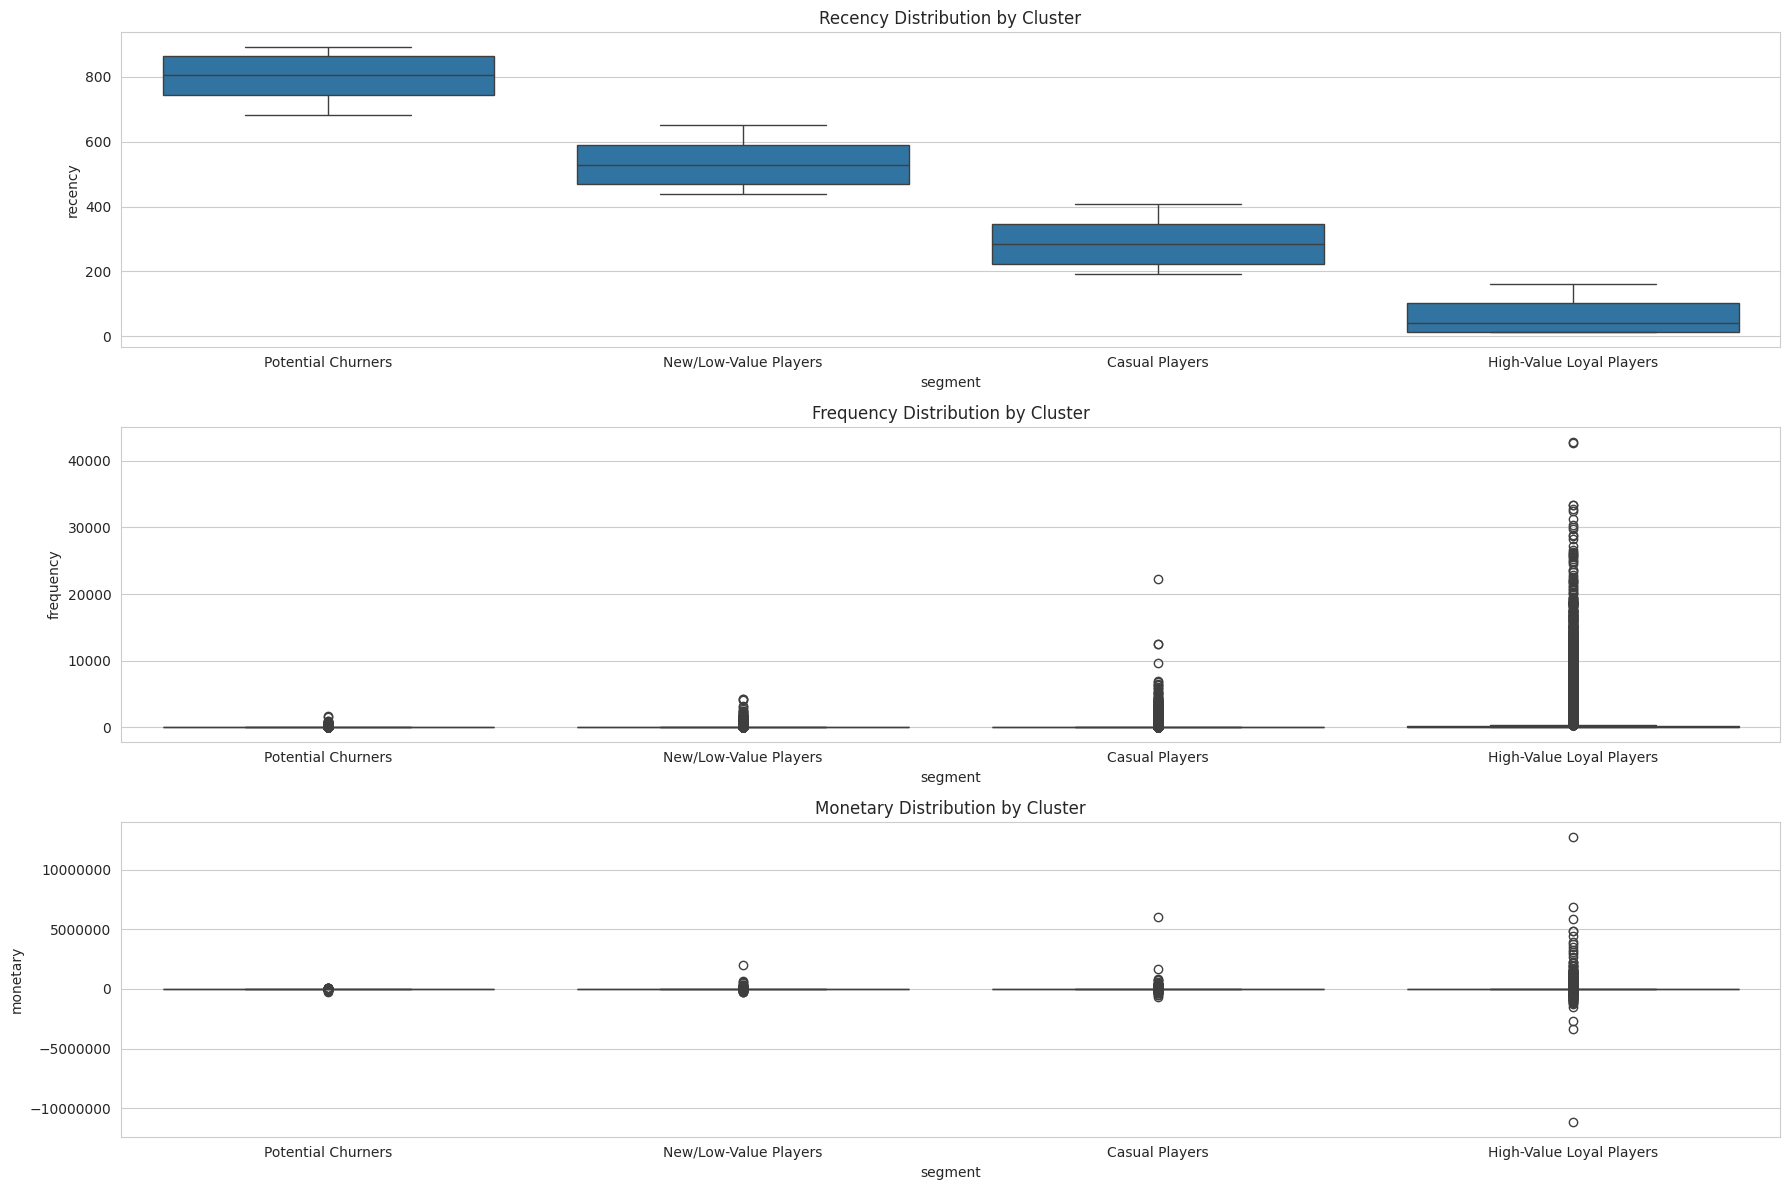

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set plot style
sns.set_style("whitegrid")

# Create a figure with three subplots arranged vertically
fig, axes = plt.subplots(3, 1, figsize=(18, 12))  # 3 rows, 1 column

# Boxplots for Recency, Frequency, and Monetary
sns.boxplot(x="segment", y="recency", data=rfm, ax=axes[0])
axes[0].set_title("Recency Distribution by Cluster")

sns.boxplot(x="segment", y="frequency", data=rfm, ax=axes[1])
axes[1].set_title("Frequency Distribution by Cluster")

sns.boxplot(x="segment", y="monetary", data=rfm, ax=axes[2])
axes[2].set_title("Monetary Distribution by Cluster")

# Format monetary axis in scientific notation
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(-10,10))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



##### Monetary Distribution (Spenders vs Winners)

                     count         mean           std           min       25%  \
monetary_segment                                                                
Spender           106774.0  4901.997579  75549.713992  0.000000e+00   21.0000   
Winner             60553.0 -3413.788893  54622.335530 -1.119076e+07 -545.1816   

                     50%        75%           max  
monetary_segment                                   
Spender           83.832  419.39076  1.277718e+07  
Winner           -31.382   -5.13240 -1.680000e-02  

--------------------------------------------------



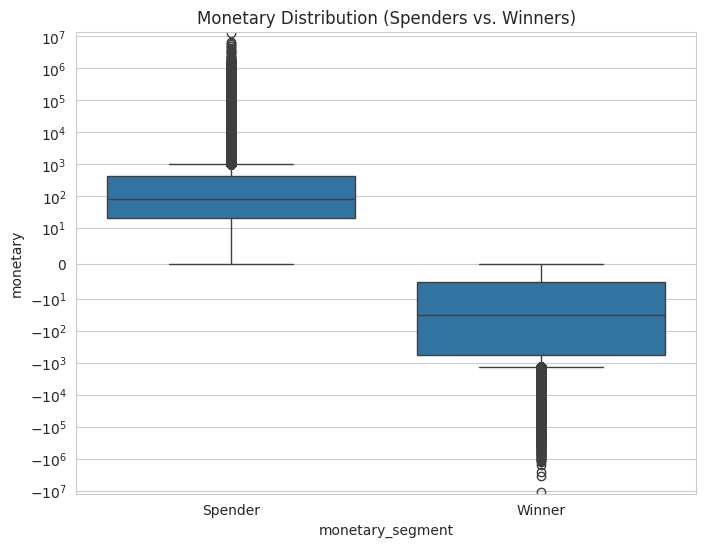

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Classify Winners & Spenders
rfm['monetary_segment'] = rfm['monetary'].apply(lambda x: 'Winner' if x < 0 else 'Spender')

# Get Summary Statistics by Segment
summary_stats = rfm.groupby('monetary_segment')['monetary'].describe()
print(summary_stats)

print("\n" + "-" * 50 + "\n")  # Adds spacing above and below the line


# Boxplot (Log Scale to Handle Outliers)
plt.figure(figsize=(8, 6))
sns.boxplot(x='monetary_segment', y='monetary', data=rfm)
plt.yscale('symlog', linthresh=10)  # Allows both negative & positive values
plt.title("Monetary Distribution (Spenders vs. Winners)")
plt.show()

##### Player Distribution Across Segments

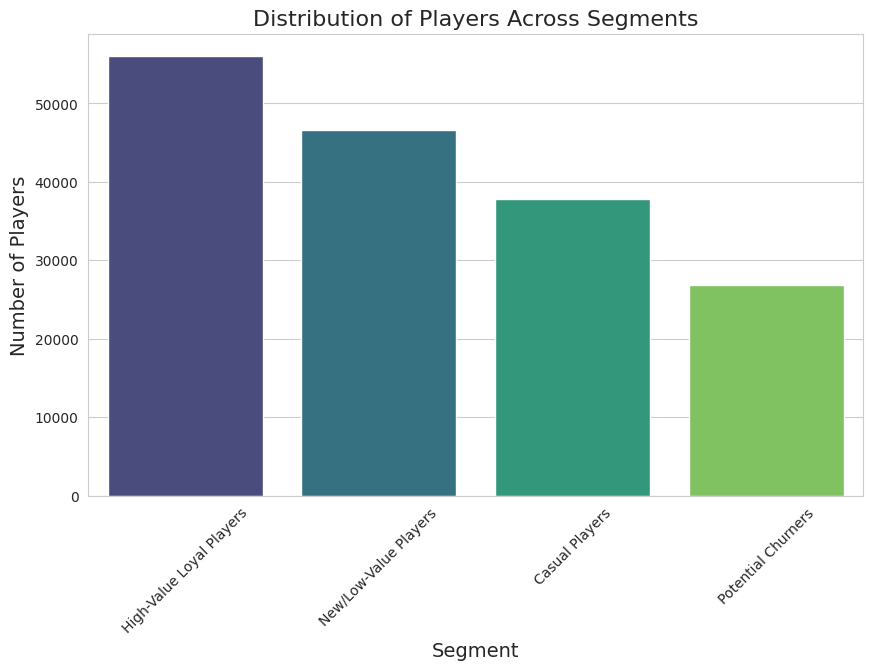

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count players in each segment
segment_counts = rfm['segment'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
plt.title("Distribution of Players Across Segments", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Number of Players", fontsize=14)
plt.xticks(rotation=45)
plt.show()

##### Average RFM Values by Segment

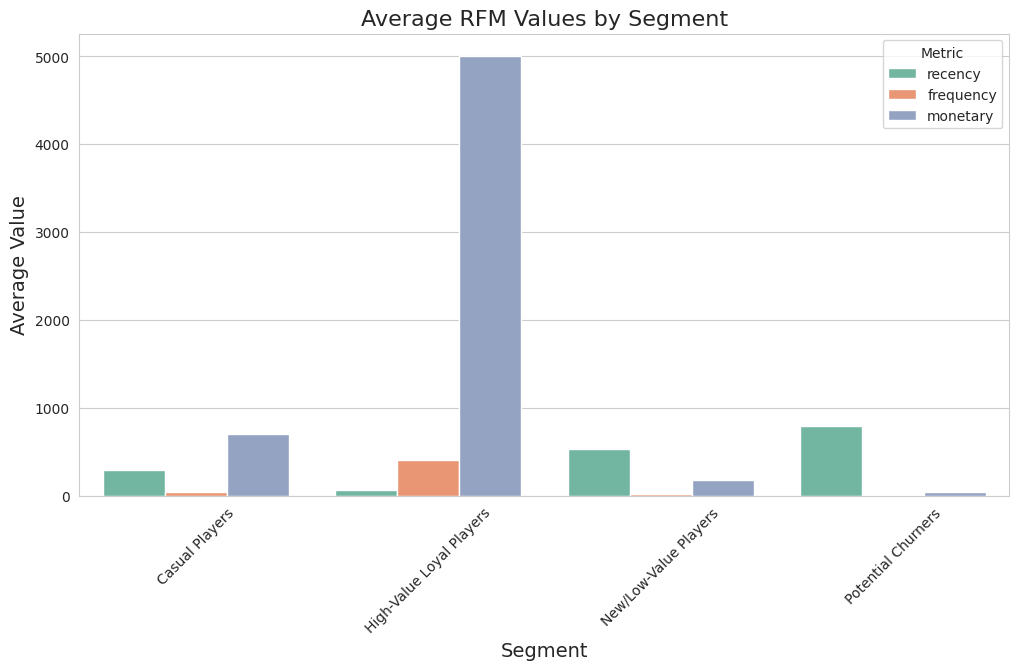

In [23]:
# Calculate average RFM values by segment
avg_rfm = rfm.groupby('segment')[['recency', 'frequency', 'monetary']].mean().reset_index()

# Melt the DataFrame for easier plotting
avg_rfm_melted = avg_rfm.melt(id_vars='segment', var_name='metric', value_name='value')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y='value', hue='metric', data=avg_rfm_melted, palette="Set2")
plt.title("Average RFM Values by Segment", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Average Value", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.show()

##### Monetary Distribution by Segment

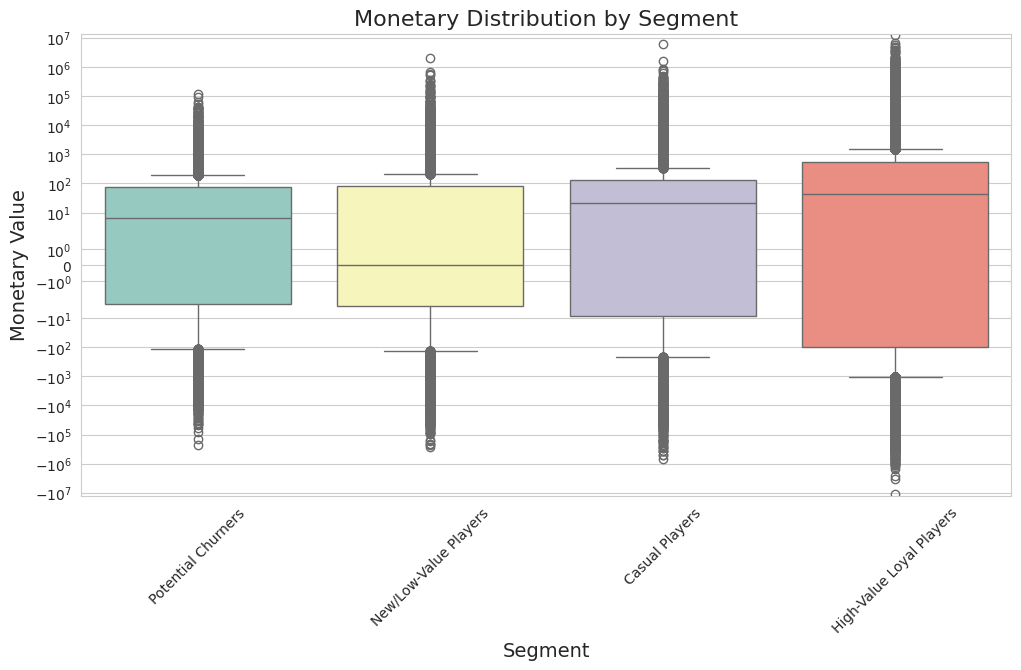

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='monetary', data=rfm, palette="Set3")
plt.title("Monetary Distribution by Segment", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Monetary Value", fontsize=14)
plt.xticks(rotation=45)
plt.yscale('symlog')  # Use log scale to handle outliers
plt.show()

##### Recency vs Frequency by Segment

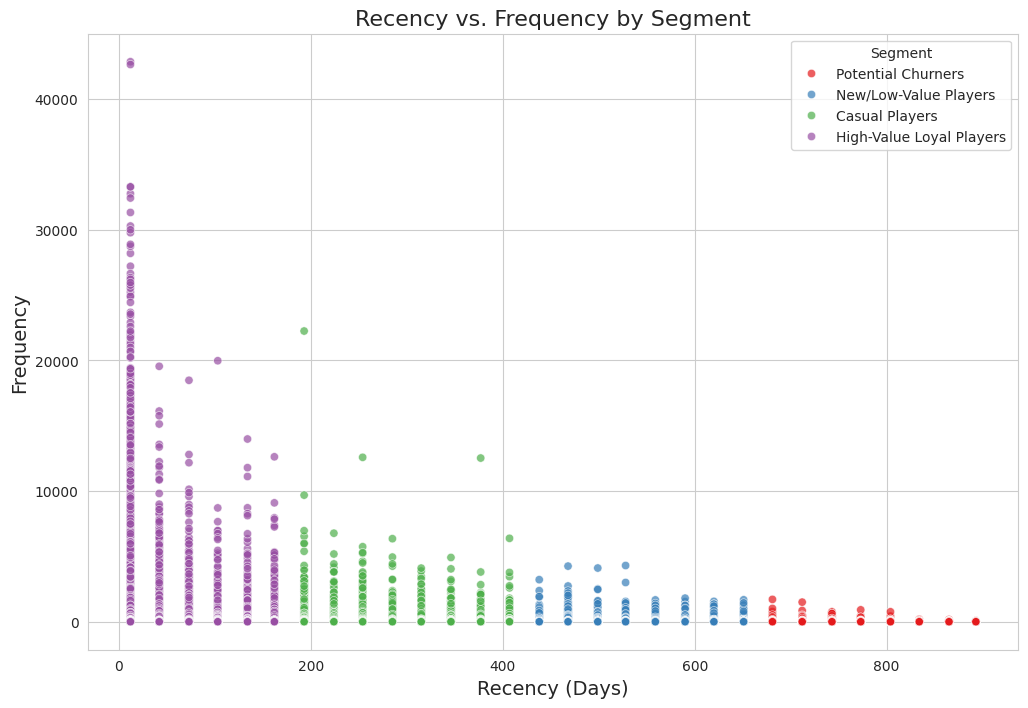

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='recency', y='frequency', hue='segment', data=rfm, palette="Set1", alpha=0.7)
plt.title("Recency vs. Frequency by Segment", fontsize=16)
plt.xlabel("Recency (Days)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Segment")
plt.show()

###### Monetary vs Frequency by Segment

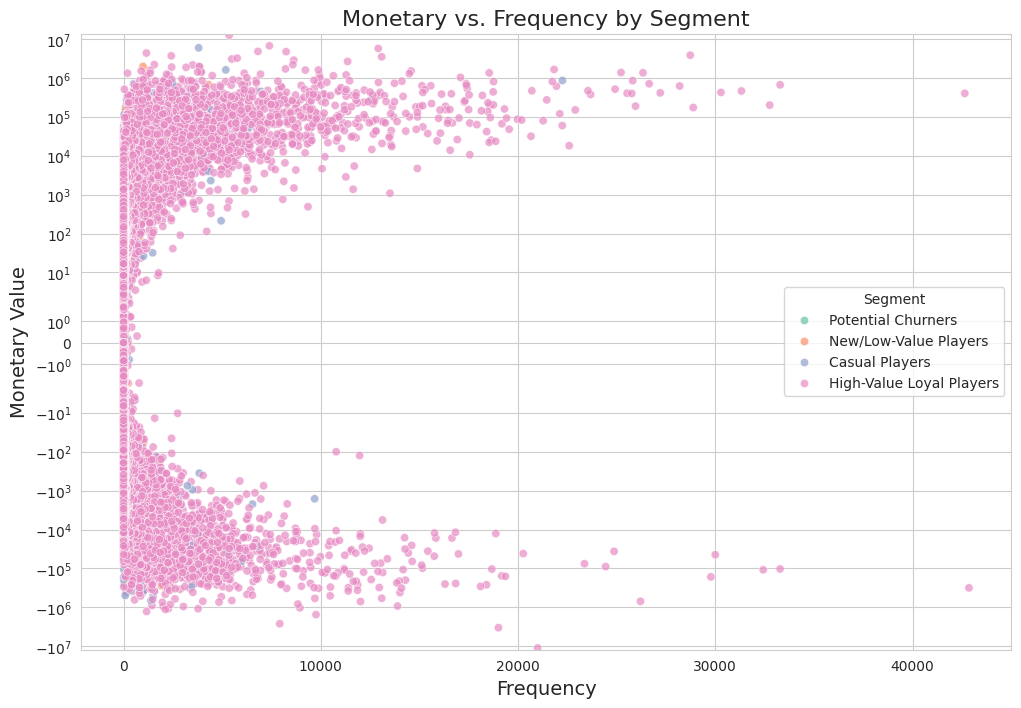

In [26]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='frequency', y='monetary', hue='segment', data=rfm, palette="Set2", alpha=0.7)
plt.title("Monetary vs. Frequency by Segment", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Monetary Value", fontsize=14)
plt.yscale('symlog')  # Use log scale to handle outliers
plt.legend(title="Segment")
plt.show()

##### Winners vs Spenders by Segment

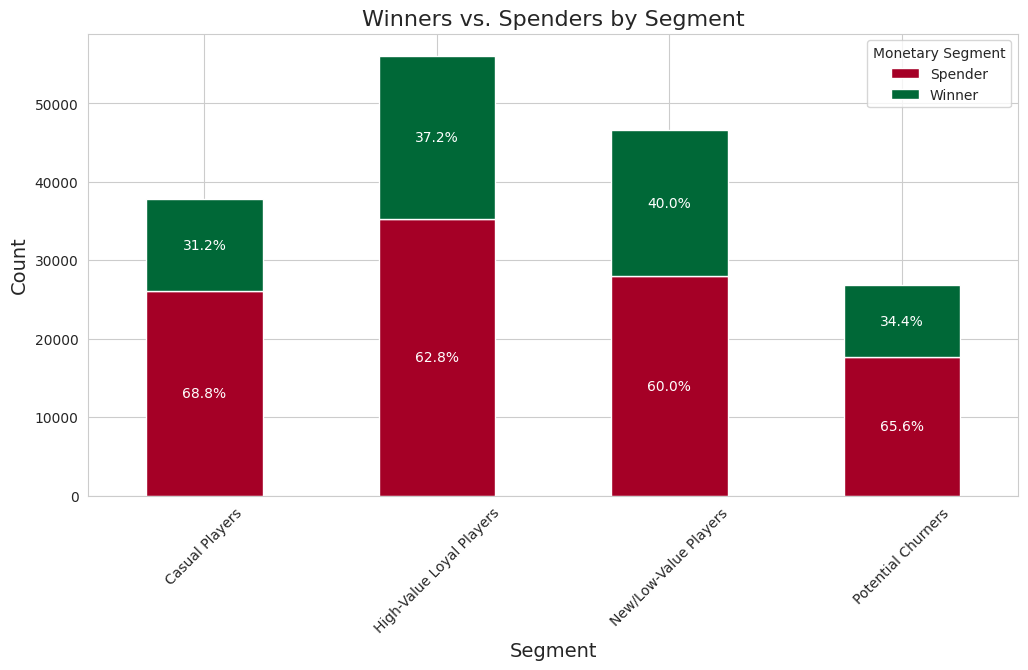

In [27]:
# Count winners and spenders by segment
winner_spender_counts = rfm.groupby(['segment', 'monetary_segment']).size().unstack()

# Calculate percentages
total_counts = winner_spender_counts.sum(axis=1)
winner_spender_percentages = winner_spender_counts.div(total_counts, axis=0) * 100

# Plot
ax = winner_spender_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="RdYlGn")
plt.title("Winners vs. Spenders by Segment", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Monetary Segment")

# Add percentages inside the bars
for i, segment in enumerate(winner_spender_counts.index):
    total = winner_spender_counts.loc[segment].sum()
    for j, monetary_segment in enumerate(winner_spender_counts.columns):
        count = winner_spender_counts.loc[segment, monetary_segment]
        percentage = winner_spender_percentages.loc[segment, monetary_segment]
        if count > 0:  # Only annotate if the count is greater than 0
            ax.text(
                i,  # x-position (segment index)
                winner_spender_counts.loc[segment, :monetary_segment].sum() - count / 2,  # y-position (middle of the bar)
                f"{percentage:.1f}%",  # Text to display (percentage)
                ha='center',  # Horizontal alignment
                va='center',  # Vertical alignment
                color='white',  # Text color
                fontsize=10  # Font size
            )

plt.show()

###### Pair Plot of RFM Metrics by Segment

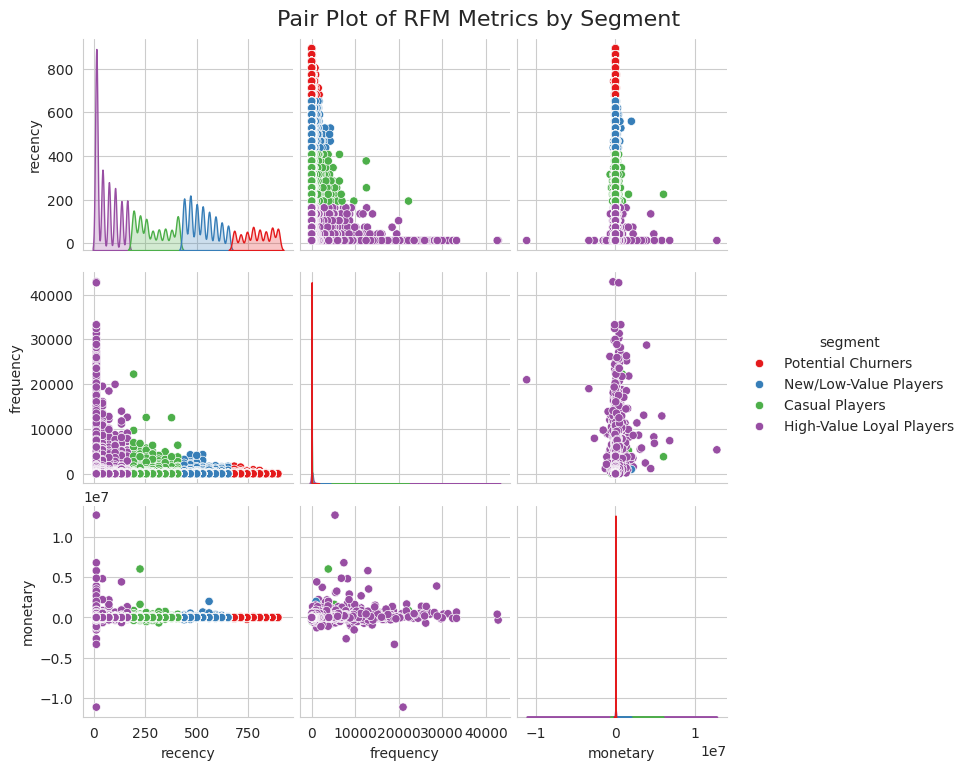

In [28]:
# Include 'segment' in the DataFrame passed to sns.pairplot()
sns.pairplot(rfm[['recency', 'frequency', 'monetary', 'segment']],
             hue='segment', palette="Set1", diag_kind='kde')
plt.suptitle("Pair Plot of RFM Metrics by Segment", y=1.02, fontsize=16)
plt.show()

## Insights on Customer Segments

- Key Characteristics
- Typical Behaviours
- Potential Value to Business

### **Player Segmentation & Growth Strategies**  

#### **1. High-Value Loyal Players**  
✔ **Traits**: Frequently active, high betting volume, significant revenue contributors.  
✔ **Value**: These are the most valuable players, driving profitability and long-term stability.  
✔ **Strategy**: Prioritize retention through VIP programs, exclusive promotions, and early access to premium features. Enhance their experience with personalized rewards and high-touch customer support.  

#### **2. Casual Players**  
✔ **Traits**: Engage occasionally, moderate betting frequency, steady revenue contribution.  
✔ **Value**: With the right engagement, they can become high-value players.  
✔ **Strategy**: Encourage higher activity through personalized promotions, gamification, and bonus incentives. Offer tailored content and betting recommendations to increase their frequency of engagement.  

#### **3. New/Low-Value Players**  
✔ **Traits**: Recently joined or rarely active, low betting amounts, minimal engagement.  
✔ **Value**: They represent a major growth opportunity if nurtured correctly.  
✔ **Strategy**: Strengthen onboarding with welcome bonuses, easy-to-understand betting guides, and low-risk promotions. Monitor early behavior to identify potential for higher engagement and intervene with targeted incentives.  

#### **4. Potential Churners**  
✔ **Traits**: Previously engaged but now inactive, significant past contributions.  
✔ **Value**: They hold high revenue potential if re-engaged effectively.  
✔ **Strategy**: Run win-back campaigns with personalized offers, deposit matches, or free bets. Use churn analysis to identify why they left and tailor messaging accordingly. Implement retention mechanisms like exclusive access to events or loyalty perks to rebuild engagement.

## Validation & Implementation of the Segmentation Model
To validate the effectiveness of the segmentation model, the following steps were taken:
1. **Cluster Summary Statistics**:
   - Calculated the average `recency`, `frequency`, and `monetary` values for each cluster to ensure they align with the defined segments.
   - Example: High-Value Loyal Players should have low recency, high frequency, and high monetary values.

2. **Visual Validation**:
   - Used visualizations (e.g., boxplots, scatter plots) to confirm that the clusters are distinct and interpretable.
   - Example: The pair plot and boxplots clearly show the separation between segments based on RFM values.

3. **Business Interpretation**:
   - Ensured that the segments align with business goals and can be acted upon.
   - Example: The "Potential Churners" segment was validated by identifying players with high recency (inactive) but previously high frequency and monetary values.

---


### Implementation Recommendations
#### **Use Cases for Segmentation**:
1. **Targeted Marketing Campaigns**:
   - Use the segments to design personalized marketing campaigns.
   - Example: Offer exclusive bonuses to High-Value Loyal Players and win-back offers to Potential Churners.

2. **Customer Retention**:
   - Focus on retaining High-Value Loyal Players and re-engaging Potential Churners.
   - Example: Implement loyalty programs and personalized communication for High-Value Loyal Players.

3. **Customer Acquisition**:
   - Use insights from Casual Players and New/Low-Value Players to improve onboarding and engagement strategies.
   - Example: Provide welcome bonuses and tutorials to New/Low-Value Players.

4. **Product Development**:
   - Tailor products and services to meet the needs of each segment.
   - Example: Develop high-stakes games for High-Value Loyal Players and low-risk games for Casual Players.

---

# 2) Retention Analysis




##### Defining an Active user & 30 days vs 90 days Retention Rate %

In [29]:

# Since 'player_activity' contains player activity data with 'src_player_id' and 'activitymonth'
# And 'player_details' contains signup dates with 'src_player_id' and 'signup_date'

# Merging activity data with signup dates
df = player_activity.merge(player_details[['src_player_id', 'signup_date']], on='src_player_id', how='left')

# Defining retention windows
df['days_since_signup'] = (df['activitymonth'] - df['signup_date']).dt.days

# 30-day retention
df['30_day_retention'] = df['days_since_signup'] <= 30
retention_30 = df.groupby('src_player_id')['30_day_retention'].max().mean() * 100

# 90-day retention
df['90_day_retention'] = df['days_since_signup'] <= 90
retention_90 = df.groupby('src_player_id')['90_day_retention'].max().mean() * 100


print("I would consider a player to be an ACTIVE player, given that they are placing a bet atleast once a week (Frequency <= 7)")
print("\n" + "-" * 50 + "\n")  # Adds spacing above and below the line
print("And the retention rates are as follows,")
print("\n")  # Adds spacing above and below the line
print(f"30-Day Retention Rate: {retention_30:.2f}%")
print(f"90-Day Retention Rate: {retention_90:.2f}%")
print("\n" + "-" * 50)  # Adds spacing above and below the line


I would consider a player to be an ACTIVE player, given that they are placing a bet atleast once a week (Frequency <= 7)

--------------------------------------------------

And the retention rates are as follows,


30-Day Retention Rate: 89.80%
90-Day Retention Rate: 94.54%

--------------------------------------------------


##### Retention Rates by Acquisition Channel (Sorted by 30-Day Retention)

Retention Rates by Acquisition Channel (Sorted by 30-Day Retention):
  acquisition_channel  retention_30  retention_90
1             Content      1.000000      1.000000
3               Email      1.000000      1.000000
0           Affiliate      0.914323      0.955600
2             Display      0.891304      0.937500
5                 PPC      0.888726      0.940311
4              Others      0.866303      0.921319
8              Social      0.839869      0.914320
7              Retail      0.813921      0.871123
6         Programatic      0.714286      0.857143


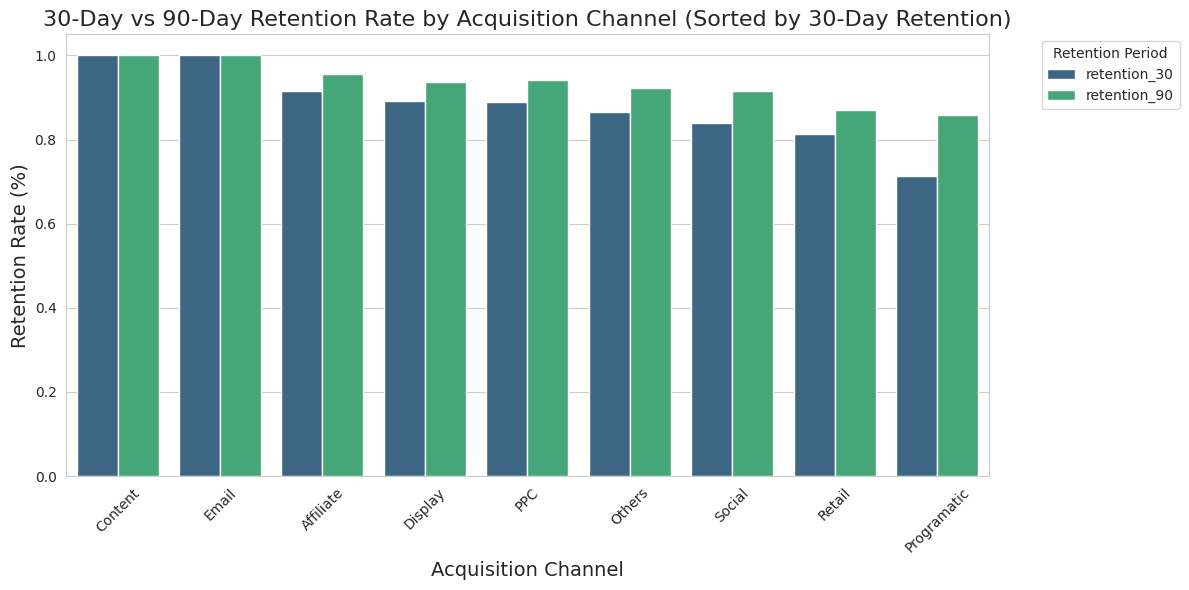

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge retention data with signup channel/platform
df_retention = df.groupby('src_player_id').agg(
    retention_30=('30_day_retention', 'max'),
    retention_90=('90_day_retention', 'max')
).reset_index()

df_retention = df_retention.merge(player_details[['src_player_id', 'acquisition_channel']], on='src_player_id', how='left')

# Calculate retention rates by acquisition channel
retention_by_channel = df_retention.groupby('acquisition_channel').agg(
    retention_30=('retention_30', 'mean'),
    retention_90=('retention_90', 'mean')
).reset_index()

# Sort by 30-day retention rate in descending order
retention_by_channel = retention_by_channel.sort_values(by='retention_30', ascending=False)

print("Retention Rates by Acquisition Channel (Sorted by 30-Day Retention):")
print(retention_by_channel)

# Melt the DataFrame for grouped bar plot
retention_melted = retention_by_channel.melt(
    id_vars=['acquisition_channel'],
    value_vars=['retention_30', 'retention_90'],
    var_name='retention_period',
    value_name='retention_rate'
)

# Plot grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='acquisition_channel',
    y='retention_rate',
    hue='retention_period',
    data=retention_melted,
    palette='viridis'
)
plt.title("30-Day vs 90-Day Retention Rate by Acquisition Channel (Sorted by 30-Day Retention)", fontsize=16)
plt.xlabel("Acquisition Channel", fontsize=14)
plt.ylabel("Retention Rate (%)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Retention Period", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Retention Rates by Product (Sorted by 30-Day Retention)

Retention Rates by Product (Sorted by 30-Day Retention):
      product  retention_30  retention_90
1  SportsBook      0.897023      0.950701
2     eGaming      0.885096      0.939085
0     Lottery      0.858907      0.919262


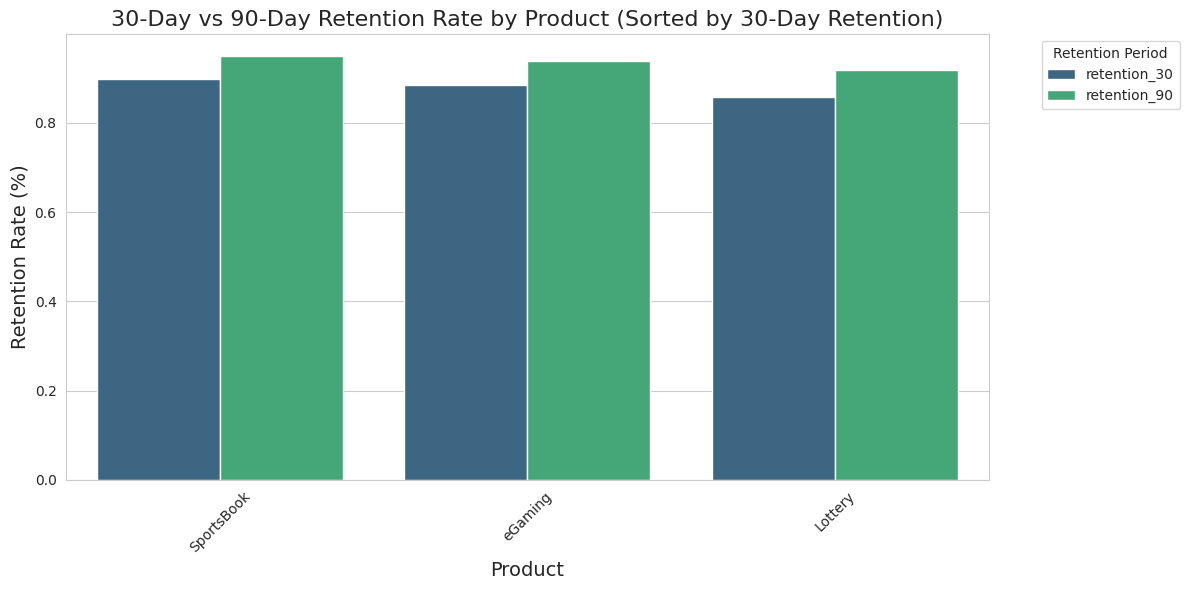

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge retention data with product information
df_retention = df.groupby('src_player_id').agg(
    retention_30=('30_day_retention', 'max'),
    retention_90=('90_day_retention', 'max')
).reset_index()

# Merge with product information from player_activity
df_retention = df_retention.merge(player_activity[['src_player_id', 'product']], on='src_player_id', how='left')

# Calculate retention rates by product
retention_by_product = df_retention.groupby('product').agg(
    retention_30=('retention_30', 'mean'),
    retention_90=('retention_90', 'mean')
).reset_index()

# Sort by 30-day retention rate in descending order
retention_by_product = retention_by_product.sort_values(by='retention_30', ascending=False)

print("Retention Rates by Product (Sorted by 30-Day Retention):")
print(retention_by_product)

# Melt the DataFrame for grouped bar plot
retention_melted = retention_by_product.melt(
    id_vars=['product'],
    value_vars=['retention_30', 'retention_90'],
    var_name='retention_period',
    value_name='retention_rate'
)

# Plot grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='product',
    y='retention_rate',
    hue='retention_period',
    data=retention_melted,
    palette='viridis'
)
plt.title("30-Day vs 90-Day Retention Rate by Product (Sorted by 30-Day Retention)", fontsize=16)
plt.xlabel("Product", fontsize=14)
plt.ylabel("Retention Rate (%)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Retention Period", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#3) Player Lifetime Value(PLV) Analysis

##### a) Method to Calculate Player Lifetime Value (PLV)

PLV is the total net revenue generated by a player over their lifetime on the platform.


It can be calculated as,

PLV
=


Average Revenue per Player per Month × Average Player Lifespan

In [35]:
import pandas as pd

# Ensure correct data types
player_activity['activitymonth'] = pd.to_datetime(player_activity['activitymonth'])
player_activity['net_gross_win'] = pd.to_numeric(player_activity['net_gross_win'], errors='coerce')
df_merged['bonus_cost'] = pd.to_numeric(df_merged['bonus_cost'], errors='coerce')

# Calculate net revenue for each player
df_merged['net_revenue'] = df_merged['net_gross_win'] - df_merged['bonus_cost']

# Aggregate player activity data
player_lifetime = df_merged.groupby('src_player_id').agg(
    total_net_revenue=('net_revenue', 'sum'),
    first_activity=('activitymonth_x', 'min'),
    last_activity=('activitymonth_x', 'max')
).reset_index()

# Calculate player lifespan in months
player_lifetime['lifespan_months'] = (
    (player_lifetime['last_activity'] - player_lifetime['first_activity']).dt.days / 30
)

# Filter out players with zero or negative lifespan
player_lifetime = player_lifetime[player_lifetime['lifespan_months'] > 0]

# Calculate average revenue per player per month
player_lifetime['avg_revenue_per_month'] = (
    player_lifetime['total_net_revenue'] / player_lifetime['lifespan_months']
)

# Calculate Player Lifetime Value (PLV)
player_lifetime['PLV'] = player_lifetime['avg_revenue_per_month'] * player_lifetime['lifespan_months']

# Sort by PLV
player_lifetime = player_lifetime.sort_values(by='PLV', ascending=False)

# Drop unnecessary index column
player_lifetime.reset_index(drop=True, inplace=True)

# Display final output
print(player_lifetime.head())


   src_player_id  total_net_revenue first_activity last_activity  \
0       13090620       1.277718e+07     2019-05-31    2021-06-30   
1       13781394       6.833929e+06     2019-10-31    2021-06-30   
2       14825026       6.052084e+06     2020-01-31    2020-11-30   
3       12347303       5.839744e+06     2019-01-31    2021-06-30   
4       12655816       4.901455e+06     2019-03-31    2021-06-30   

   lifespan_months  avg_revenue_per_month           PLV  
0        25.366667          503699.554571  1.277718e+07  
1        20.266667          337200.456267  6.833929e+06  
2        10.133333          597245.089342  6.052084e+06  
3        29.366667          198856.222883  5.839744e+06  
4        27.400000          178885.217801  4.901455e+06  


##### Distribution of Player Lifetime Value (PLV) by Lisespan

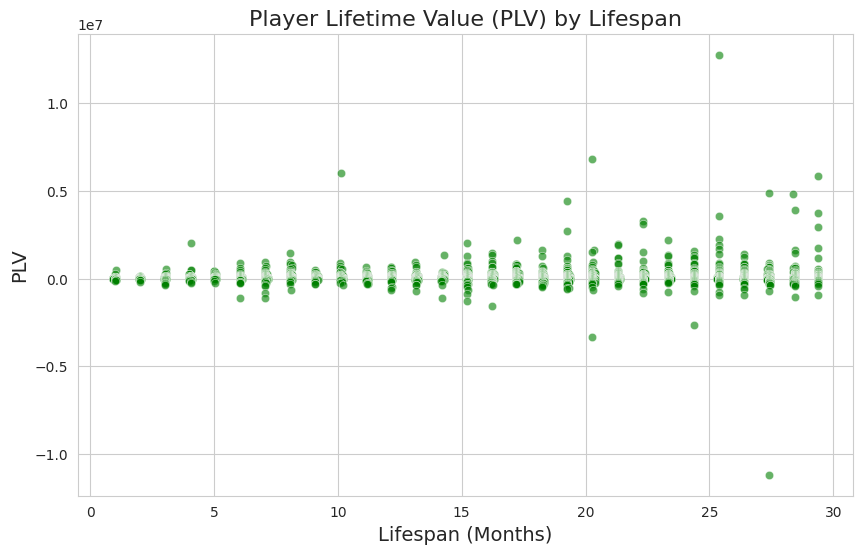

In [36]:
# Scatter plot: Lifespan vs PLV
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lifespan_months', y='PLV', data=player_lifetime, alpha=0.6, color='green')
plt.title("Player Lifetime Value (PLV) by Lifespan", fontsize=16)
plt.xlabel("Lifespan (Months)", fontsize=14)
plt.ylabel("PLV", fontsize=14)
plt.show()

##### Average Revenue per Month by Lifespan


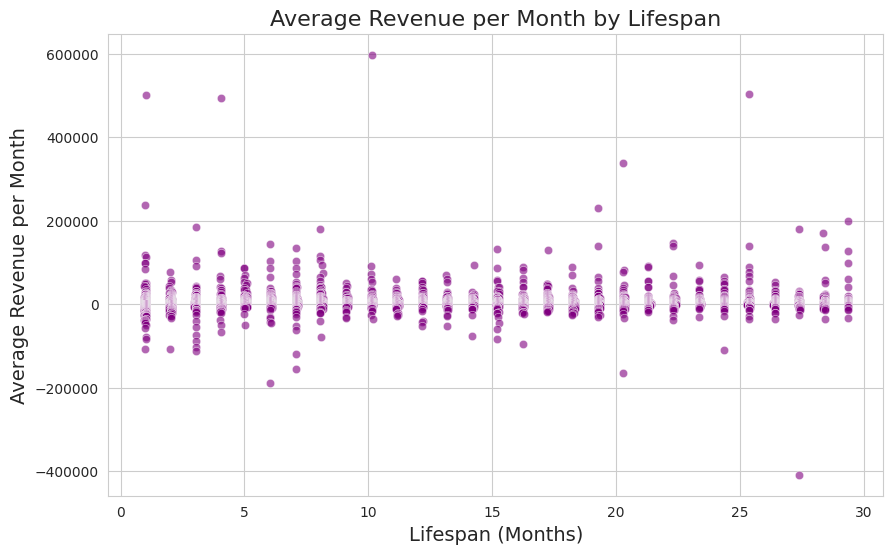

In [37]:
# Scatter plot: Lifespan vs Average Revenue per Month
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lifespan_months', y='avg_revenue_per_month', data=player_lifetime, alpha=0.6, color='purple')
plt.title("Average Revenue per Month by Lifespan", fontsize=16)
plt.xlabel("Lifespan (Months)", fontsize=14)
plt.ylabel("Average Revenue per Month", fontsize=14)
plt.show()

##### Average PLV by First Activity Year

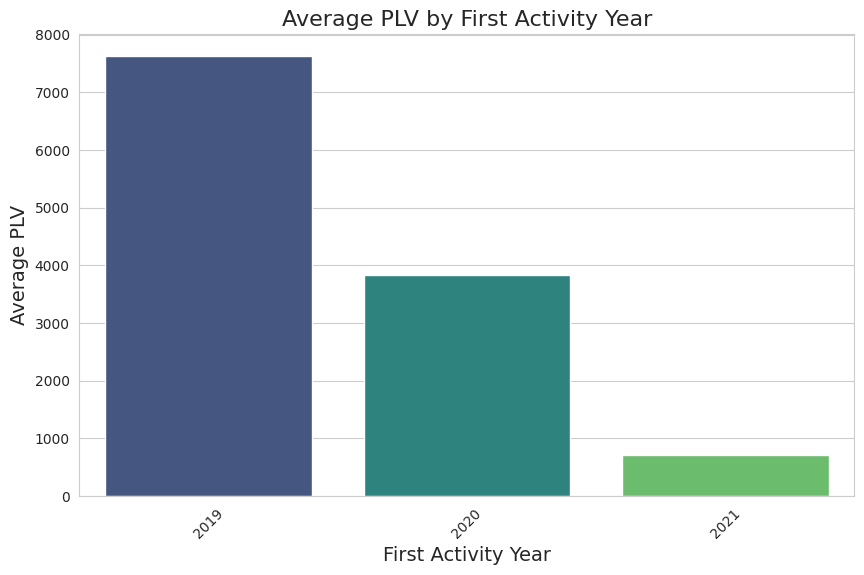

In [38]:
# Extract year from first_activity
player_lifetime['first_activity_year'] = player_lifetime['first_activity'].dt.year

# Calculate average PLV by year
plv_by_year = player_lifetime.groupby('first_activity_year')['PLV'].mean().reset_index()

# Bar plot: Average PLV by First Activity Year
plt.figure(figsize=(10, 6))
sns.barplot(x='first_activity_year', y='PLV', data=plv_by_year, palette='viridis')
plt.title("Average PLV by First Activity Year", fontsize=16)
plt.xlabel("First Activity Year", fontsize=14)
plt.ylabel("Average PLV", fontsize=14)
plt.xticks(rotation=45)
plt.show()

##### Top 10 Players by PLV

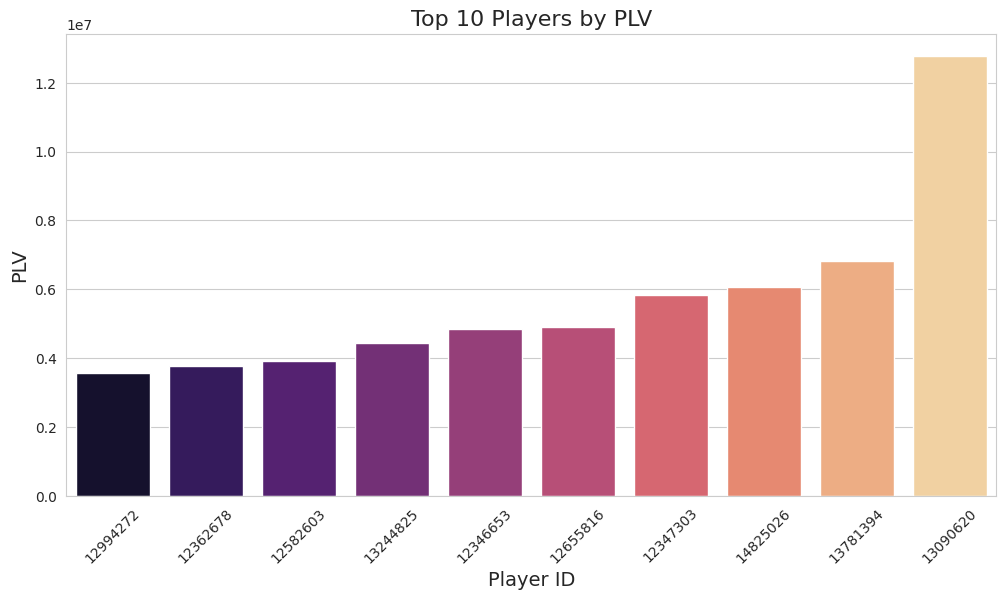

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort players by PLV in descending order
top_players = player_lifetime.sort_values(by='PLV', ascending=False).head(10)

# Bar plot: Top 10 Players by PLV (Ensuring descending order in visualization)
plt.figure(figsize=(12, 6))
sns.barplot(x='src_player_id', y='PLV', data=top_players, palette='magma',
            order=top_players.sort_values(by='PLV', ascending=True)['src_player_id'])  # Ensuring descending order visually

# Labels and title
plt.title("Top 10 Players by PLV", fontsize=16)
plt.xlabel("Player ID", fontsize=14)
plt.ylabel("PLV", fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.show()


##### Correlation between First Deposit Amount and PLV

Correlation between First Deposit Amount and PLV: 0.01
Spearman Correlation: 0.05


This suggests that the correlation is very weak in nature.

--------------------------------------------------



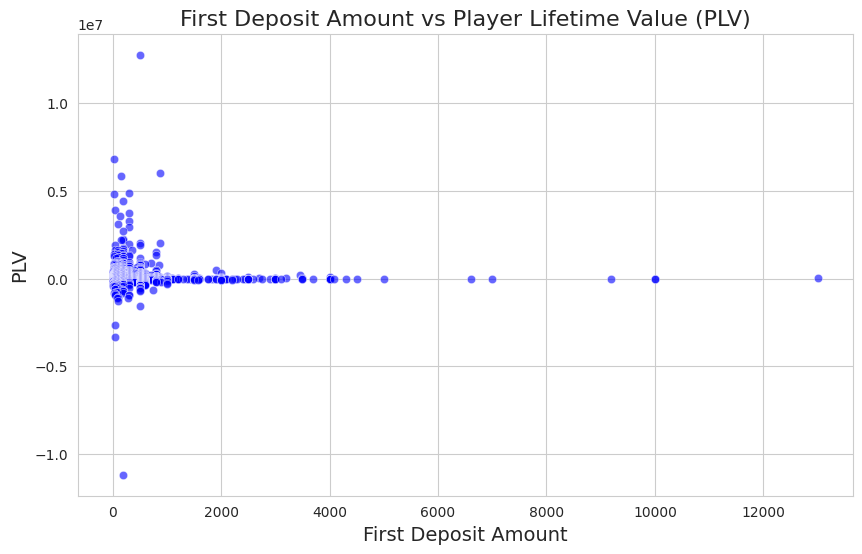

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Merge first deposit data with player lifetime data
player_lifetime = player_lifetime.drop(columns=['first_deposit_amount'], errors='ignore')

player_lifetime = player_lifetime.merge(
    first_deposit[['src_player_id', 'first_deposit_amount']],
    on='src_player_id',
    how='left'
)

# Drop rows with missing first deposit amounts (if any)
player_lifetime = player_lifetime.dropna(subset=['first_deposit_amount'])

# Calculate correlation between first deposit amount and PLV
correlation = player_lifetime['first_deposit_amount'].corr(player_lifetime['PLV'])
print(f"Correlation between First Deposit Amount and PLV: {correlation:.2f}")

spearman_corr = player_lifetime['first_deposit_amount'].corr(player_lifetime['PLV'], method='spearman')
print(f"Spearman Correlation: {spearman_corr:.2f}")


print("\n")

print("This suggests that the correlation is very weak in nature.")

print("\n"+ "-"*50 + "\n")

# Scatter plot: First Deposit Amount vs PLV
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='first_deposit_amount',
    y='PLV',
    data=player_lifetime,
    alpha=0.6,
    color='blue'
)
plt.title("First Deposit Amount vs Player Lifetime Value (PLV)", fontsize=16)
plt.xlabel("First Deposit Amount", fontsize=14)
plt.ylabel("PLV", fontsize=14)
plt.show()

### Overall Player Lifetime Value (PLV) Insights:

- PLV calculation confirms that total revenue aligns closely with a player’s active lifespan.

- Recommendation: Consider predictive modeling to estimate future PLV beyond historical data, allowing more proactive retention strategies.

### Limitations and Additional Data Suggestions

####Data Gaps in Player Behavior:

- Current dataset lacks details on user preferences, session durations, and specific betting behaviors.

- We could Integrate in-game behavioral tracking and segmentation based on bet types.

####Lack of Marketing Attribution:

- No clear connection between marketing efforts and player acquisition/retention.

- We could Include campaign exposure data to analyze ROI on promotions and optimize spend. (Data like CPC, CPI & CPA)

####No External Influences Considered:

- Economic conditions, seasonal trends, or competitor influence are not accounted for.

- We could Incorporate external datasets (e.g., economic indicators, industry trends) to refine retention and acquisition models.

####Limited Predictive Metrics:

- Analysis is retrospective rather than predictive.

- We could Implement machine learning models to forecast churn likelihood and future revenue contributions per player segment.